# Numerical solution of 2D Heat transfer equation
The heat equation is  
$$
\frac{\partial \theta}{\partial t}
= \alpha \nabla^2 \theta
$$

- $\theta$ ... temperature
- a ... thermal diffusivity
- t ... time

## Transforming the heat equation into two dimensions and discrete form:
1. General Derivative
$$
\frac{df}{dx} \approx \frac{f(x + \Delta x) - f(x)}{\Delta x}
$$

2. Derivatives of the heat transfer in x-direction
$$
\frac{\partial \theta}{\partial x}\bigg|_{m,j}
\approx 
\frac{\theta_{i+1} - \theta_i}{\Delta x}
$$
$$
\frac{\partial^2 \theta}{\partial x^2}\bigg|_{m,j}
\approx 
\frac{\theta_{i+1} - 2\theta_i + \theta_{i-1}}{\Delta x^2}
$$

3. Derivatives of the heat transfer in y-direction
$$
\frac{\partial \theta}{\partial y}\bigg|_{m,i}
\approx 
\frac{\theta_{j+1} - \theta_j}{\Delta y}
$$
$$
\frac{\partial^2 \theta}{\partial y^2}\bigg|_{m,i}
\approx 
\frac{\theta_{j+1} - 2\theta_j + \theta_{j-1}}{\Delta y^2}
$$

4. Derivatives of the heat transfer over time
$$
\frac{\partial \theta}{\partial t}\bigg|_{i,j}
\approx 
\frac{\theta^{m+1} - \theta^m}{\Delta t}
$$


5. Putting everything in the heat equation

$$
\frac{\theta_{i,j}^{m+1} - \theta_{i,j}^m}{\Delta t}
=
a
\left(
\frac{\theta_{i+1,j}^m - 2\theta_{i,j}^m + \theta_{i-1,j}^m}{\Delta x^2}
+
\frac{\theta_{i,j+1}^m - 2\theta_{i,j}^m + \theta_{i,j-1}^m}{\Delta y^2}
\right)
$$

6. Assumption of a uniform square as a cell ($\Delta x = \Delta y$)

$$
\frac{\theta_{i,j}^{m+1} - \theta_{i,j}^m}{\Delta t}
=
a
\left(
\frac{\theta_{i+1, j}^m  + \theta_{i-1, j}^m + \theta_{i,j+1}^m  + \theta_{i,j-1}^m - 4\theta_{i,j}^m}{\Delta x^2}
\right)
$$

7. Rearranging for $\theta_{i,j}^{m+1}$

$$
\theta_{i,j}^{m+1}
=
\theta_{i,j}^m
+
\frac{a \Delta t}{\Delta x^2}
\left(
\theta_{i+1, j}^m  + \theta_{i-1, j}^m + \theta_{i,j+1}^m  + \theta_{i,j-1}^m - 4\theta_{i,j}^m
\right)
$$


## Applying the discrete heat transfer equation

### Imports

In [101]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import numba
from numba import prange
from IPython.display import Video
import datetime

### Creating the meshgrid / Loading Image

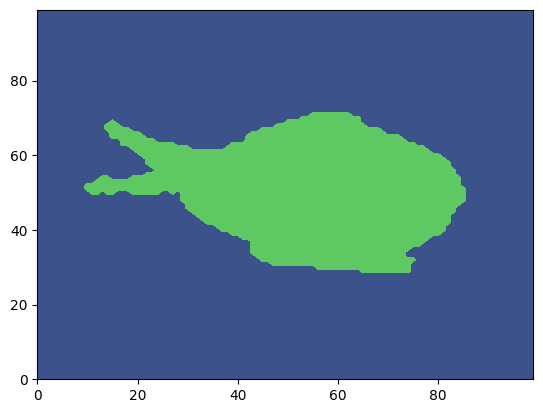

In [102]:
# Image
img = iio.imread('../img/turkey.png') # Load image
img = np.flip(img, axis=0)  # Flip the image vertically
boolean_matrix = np.zeros([img.shape[0], img.shape[1]], dtype=bool)
boolean_matrix[:, :] = [value for value in (img[:, :, 0] < 200)]  # Create boolean matrix of the turkey region
plt.contourf(boolean_matrix)  # Plot the boolean matrix

### Calculating the heatmap

Defining the Parameters

In [103]:
# Parameters
a = 1.32e-7  # Diffusion constant

# discretization
dx = 0.5 / 100
dt = 1
times = int(8*3600)# total time in seconds
num_snapshots = int(8*360)
step = int(times / num_snapshots) # Snapshot every 10 steps

# Initial temperatures
theta_0_oven = 165.0 + 273.15 # K
theta_0_turkey = 20.0 + 273.15 # K

In [104]:
heatmap = np.zeros((img.shape[0], img.shape[1]), dtype=float) # Heatmap in °C
heatmap[boolean_matrix] = theta_0_turkey
heatmap[~boolean_matrix] = theta_0_oven


In [105]:
def solve_heat_equation(heatmap, boolean_matrix, a, dx, dt):
  cs = heatmap.copy() # current state
  cf = 0 # current frame
  length = len(cs[0])
  frames = []
  coeff = a * dt / dx**2
  for m in range(1, times):
    ns = cs.copy() # new state
    for i in range(1, length - 1):
      for j in range(1, length - 1):
        if boolean_matrix[i, j]: # Only update turkey region
          ns[i, j] = cs[i, j] + coeff * (cs[i+1, j] + cs[i-1, j] + cs[i, j+1] + cs[i, j-1] - 4 * cs[i, j])
    cs = ns.copy()

    if m % step == 0:
      cf += 1
      frames.append(cs)
      #print(f"Computed frame {cf} at time {m} seconds")

  return frames

In [106]:
heat_frames = solve_heat_equation(heatmap, boolean_matrix, a, dx, dt)
heat_frames = np.array(heat_frames)  # Convert list to numpy array
heat_frames -= 273.15  # Convert to Celsius

### Live Plot of the Heat Transfer 

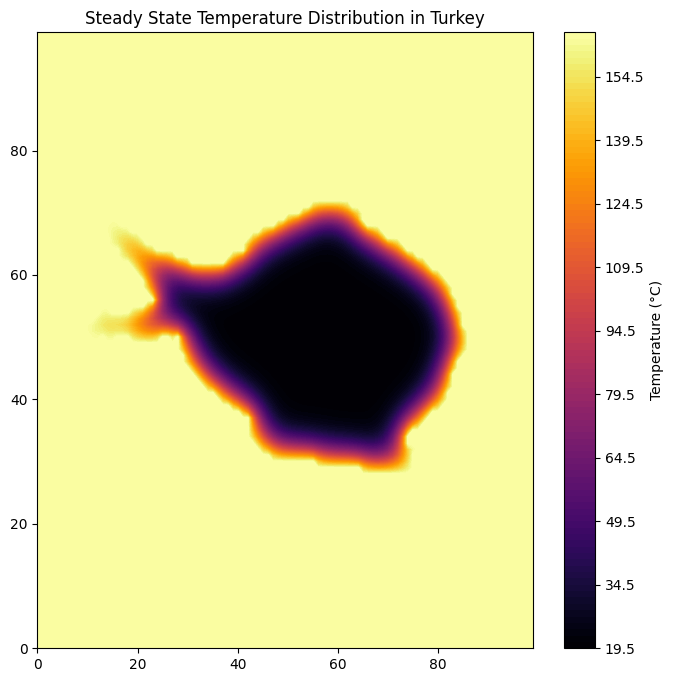

In [107]:
# steady state plot
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
cont = plt.contourf(heat_frames[100], 100, cmap=cmap)
plt.colorbar(cont, label='Temperature (°C)')
plt.title('Steady State Temperature Distribution in Turkey')
plt.show()

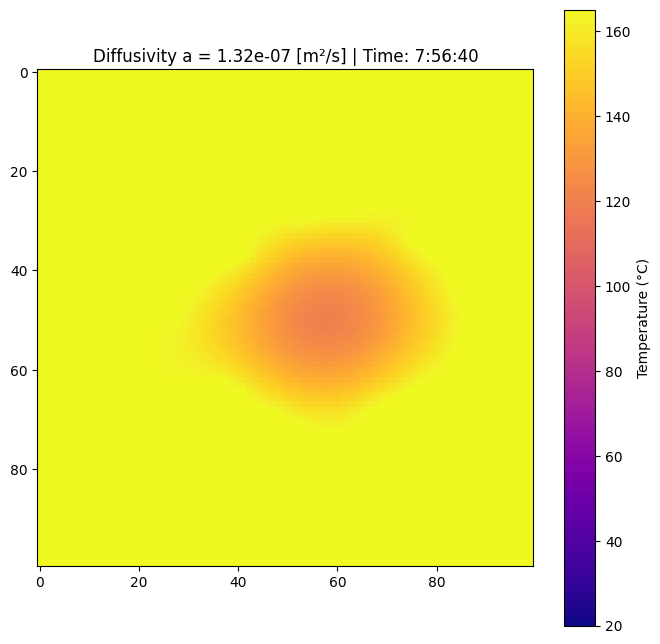

In [108]:
# Live animation
fig, ax = plt.subplots(figsize=(8,8))
vmin = theta_0_turkey - 273.15
vmax = theta_0_oven - 273.15
fast_forward = 10  # show every 20th frame

# use imshow and update the image data for faster/more reliable animation in notebooks
im = ax.imshow(heat_frames[0], cmap='plasma', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax, label='Temperature (°C)')
def animate(i):
  im.set_data(heat_frames[i*fast_forward])
  # compute real time for this snapshot: i * step * dt (seconds)
  seconds = int(i*fast_forward * step * dt)
  time_str = str(datetime.timedelta(seconds=seconds))
  ax.set_title(f'Diffusivity a = {a} [m²/s] | Time: {time_str}')
  return [im]
ani = animation.FuncAnimation(fig, animate, frames=heat_frames.shape[0]//fast_forward, interval=200, blit=True)
ani.save('../img/heat_anim.gif', writer=PillowWriter(fps=30))

### Average and Minimum Temperature 

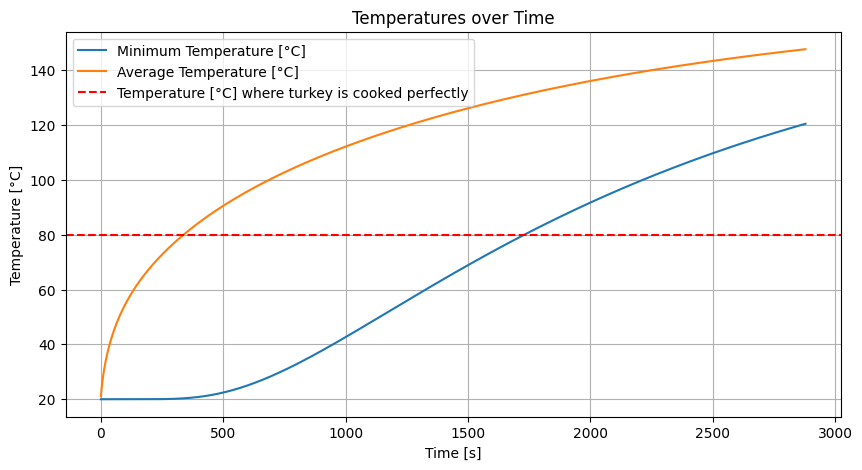

In [109]:
min_temperatures = np.array([])
average_temperatures = np.array([])
for frame in heat_frames:
    min_temperatures = np.append(min_temperatures, np.min(frame[boolean_matrix]))
    average_temperatures = np.append(average_temperatures, np.mean(frame[boolean_matrix]))
plt.figure(figsize=(10,5))
plt.plot(min_temperatures, label='Minimum Temperature [°C]')
plt.plot(average_temperatures, label='Average Temperature [°C]')
plt.axhline(80, color='red', linestyle='--', label='Temperature [°C] where turkey is cooked perfectly')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Temperatures over Time')
plt.legend()
plt.grid()
plt.savefig('../img/heat_analysis.png', dpi=300)
plt.show()
